![spam](img/JB3.png)

In [1]:
import warnings
warnings.filterwarnings('ignore')

## 1.   Importing libraries, functions and model

In [2]:
# Basic libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# Normalization libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error, r2_score
from sklearn.decomposition import PCA

#Tensorflow con keras
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import layers
from tensorflow.keras.models import load_model

# Easy graphs with plotly
import plotly.express as px
import plotly.graph_objects as go

# Matplotlib graphics custumization
plt.style.use('ggplot')
plt.rcParams['figure.figsize'] = (15,7)
import pickle as pk

!pip install openpyxl
# import xlrd

# Statistics
import scipy
from scipy import stats

In [3]:
# Getting PCA functions
%run "./funciones/pcafunction.ipynb"

In [4]:
# Getting the model
modelo = load_model("./outputs/h5/modelo.h5")

Metal device set to: Apple M1 Max


2022-08-12 19:58:54.693882: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-12 19:58:54.694010: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


<summary>
    <font size="4" color="orange"><b>1.1 Setting the parameters according to the tensors created in JNB1</b></font>
</summary>


In [5]:
n_pasado = (24 * 7) + 12
n_futuro = 24
n_salto = 12

## 2.   Dataset preprocessing

* The last time-line instance has to be the day before you want to forecast at 11:00:00. e.g. if we want to make the forecast for December 13, 2021, the last instance has to be 2021-12-12 11:00:00
* We also create the data frame with holidays information of the day to forecast

<summary>
    <font size="4" color="orange"><b>1.1 Loading CENACE database </b></font>
</summary>

In [6]:
url = "./inputs/Dataset GCRNO120522 DF.xlsx" #data #data
gcrno = pd.read_excel(url)

<summary>
    <font size="4" color="orange"><b>1.2. Dataframe rearrangement</b></font>
</summary>

In [7]:
# Transposing hours columns from the original dataframe into rows
consumo_data = gcrno.melt(
    id_vars= ['FECHA'],
    value_vars= [f'DEM_GCRNO_H{i}' for i in range(24)],
    var_name="Hora",
    value_name="Demanda"
).replace(
    {f'DEM_GCRNO_H{i}': i for i in range(24)}
)

consumo_data.index = consumo_data.FECHA + pd.to_timedelta(consumo_data.Hora, unit='h')
consumo_data.sort_index(inplace=True)
consumo_data.drop(columns=['Hora'], inplace=True)
consumo_data = consumo_data.asfreq('H', method='pad')
consumo_data['Fecha-Hora'] = consumo_data.index
consumo_data["Dia"] = consumo_data.index.weekday
consumo_data["Hora"] = consumo_data.index.hour
consumo_data["Mes"] = consumo_data.index.month

In [8]:
# Adding columns of exogenous variables
exogenas = gcrno[['FECHA','TMAX-CAB', 'TMAX-HMO', 'TMAX-OBR', 'TMAX-LMO', 'TMAX-CUL', 'TMIN-CAB',
       'TMIN-HMO', 'TMIN-OBR', 'TMIN-LMO', 'TMIN-CUL', 'PREC_HMO_MM',
       'PREC_OBR_MM', 'PREC_LMO_MM', 'PREC_CUL_MM', 'LUNES_FESTIVO',
       'MARTES_POSTFESTIVO', 'SEMANA_SANTA', '1_MAYO', '10_MAYO', '16_SEP',
       '2_NOV.', 'PRE-NAVIDAD_Y_NEW_YEAR', 'NAVIDAD_Y_NEW_YEAR',
       'POST-NAVIDAD_Y_NEW_YEAR']]
consumo = pd.merge(consumo_data, exogenas, on='FECHA', how='left')

In [9]:
# Setting as index the DATE-HOUR
consumo.set_index("Fecha-Hora", inplace=True)
consumo=consumo.asfreq('h')
consumo['Fecha-Hora'] = consumo.index

# Result
consumo

,FECHA,Demanda,Dia,Hora,Mes,TMAX-CAB,TMAX-HMO,TMAX-OBR,TMAX-LMO,TMAX-CUL,...,MARTES_POSTFESTIVO,SEMANA_SANTA,1_MAYO,10_MAYO,16_SEP,2_NOV.,PRE-NAVIDAD_Y_NEW_YEAR,NAVIDAD_Y_NEW_YEAR,POST-NAVIDAD_Y_NEW_YEAR,Fecha-Hora
Fecha-Hora,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,2007-01-01,1394,0,0,1,21.0,22.0,25.0,30.0,29.0,...,0,0,0,0,0,0,0,1,0,2007-01-01 00:00:00
2007-01-01 01:00:00,2007-01-01,1297,0,1,1,21.0,22.0,25.0,30.0,29.0,...,0,0,0,0,0,0,0,1,0,2007-01-01 01:00:00
2007-01-01 02:00:00,2007-01-01,1255,0,2,1,21.0,22.0,25.0,30.0,29.0,...,0,0,0,0,0,0,0,1,0,2007-01-01 02:00:00
2007-01-01 03:00:00,2007-01-01,1222,0,3,1,21.0,22.0,25.0,30.0,29.0,...,0,0,0,0,0,0,0,1,0,2007-01-01 03:00:00
2007-01-01 04:00:00,2007-01-01,1168,0,4,1,21.0,22.0,25.0,30.0,29.0,...,0,0,0,0,0,0,0,1,0,2007-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-12 19:00:00,2022-05-12,3861,3,19,5,34.0,37.0,38.0,36.0,40.0,...,0,0,0,0,0,0,0,0,0,2022-05-12 19:00:00
2022-05-12 20:00:00,2022-05-12,3668,3,20,5,34.0,37.0,38.0,36.0,40.0,...,0,0,0,0,0,0,0,0,0,2022-05-12 20:00:00
2022-05-12 21:00:00,2022-05-12,3692,3,21,5,34.0,37.0,38.0,36.0,40.0,...,0,0,0,0,0,0,0,0,0,2022-05-12 21:00:00


In [10]:
consumo = consumo[consumo['Fecha-Hora']< '2022-04-30 00:00:00']
consumo

,FECHA,Demanda,Dia,Hora,Mes,TMAX-CAB,TMAX-HMO,TMAX-OBR,TMAX-LMO,TMAX-CUL,...,MARTES_POSTFESTIVO,SEMANA_SANTA,1_MAYO,10_MAYO,16_SEP,2_NOV.,PRE-NAVIDAD_Y_NEW_YEAR,NAVIDAD_Y_NEW_YEAR,POST-NAVIDAD_Y_NEW_YEAR,Fecha-Hora
Fecha-Hora,,,,,,,,,,,,,,,,,,,,,
2007-01-01 00:00:00,2007-01-01,1394,0,0,1,21.0,22.0,25.0,30.0,29.0,...,0,0,0,0,0,0,0,1,0,2007-01-01 00:00:00
2007-01-01 01:00:00,2007-01-01,1297,0,1,1,21.0,22.0,25.0,30.0,29.0,...,0,0,0,0,0,0,0,1,0,2007-01-01 01:00:00
2007-01-01 02:00:00,2007-01-01,1255,0,2,1,21.0,22.0,25.0,30.0,29.0,...,0,0,0,0,0,0,0,1,0,2007-01-01 02:00:00
2007-01-01 03:00:00,2007-01-01,1222,0,3,1,21.0,22.0,25.0,30.0,29.0,...,0,0,0,0,0,0,0,1,0,2007-01-01 03:00:00
2007-01-01 04:00:00,2007-01-01,1168,0,4,1,21.0,22.0,25.0,30.0,29.0,...,0,0,0,0,0,0,0,1,0,2007-01-01 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29 19:00:00,2022-04-29,3294,4,19,4,30.0,37.0,35.0,36.0,37.0,...,0,0,0,0,0,0,0,0,0,2022-04-29 19:00:00
2022-04-29 20:00:00,2022-04-29,3123,4,20,4,30.0,37.0,35.0,36.0,37.0,...,0,0,0,0,0,0,0,0,0,2022-04-29 20:00:00
2022-04-29 21:00:00,2022-04-29,3170,4,21,4,30.0,37.0,35.0,36.0,37.0,...,0,0,0,0,0,0,0,0,0,2022-04-29 21:00:00


In [11]:
consumo.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 134352 entries, 2007-01-01 00:00:00 to 2022-04-29 23:00:00
Freq: H
Data columns (total 30 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   FECHA                    134352 non-null  datetime64[ns]
 1   Demanda                  134352 non-null  int64         
 2   Dia                      134352 non-null  int64         
 3   Hora                     134352 non-null  int64         
 4   Mes                      134352 non-null  int64         
 5   TMAX-CAB                 134352 non-null  float64       
 6   TMAX-HMO                 134352 non-null  float64       
 7   TMAX-OBR                 134352 non-null  float64       
 8   TMAX-LMO                 134352 non-null  float64       
 9   TMAX-CUL                 134352 non-null  float64       
 10  TMIN-CAB                 134352 non-null  float64       
 11  TMIN-HMO                 134352 non-

In [12]:
consumo_pre = consumo.iloc[-(n_pasado + n_salto):-12]
consumo_pre

,FECHA,Demanda,Dia,Hora,Mes,TMAX-CAB,TMAX-HMO,TMAX-OBR,TMAX-LMO,TMAX-CUL,...,MARTES_POSTFESTIVO,SEMANA_SANTA,1_MAYO,10_MAYO,16_SEP,2_NOV.,PRE-NAVIDAD_Y_NEW_YEAR,NAVIDAD_Y_NEW_YEAR,POST-NAVIDAD_Y_NEW_YEAR,Fecha-Hora
Fecha-Hora,,,,,,,,,,,,,,,,,,,,,
2022-04-22 00:00:00,2022-04-22,3169,4,0,4,32.0,35.0,34.0,34.0,35.0,...,0,0,0,0,0,0,0,0,0,2022-04-22 00:00:00
2022-04-22 01:00:00,2022-04-22,3055,4,1,4,32.0,35.0,34.0,34.0,35.0,...,0,0,0,0,0,0,0,0,0,2022-04-22 01:00:00
2022-04-22 02:00:00,2022-04-22,2918,4,2,4,32.0,35.0,34.0,34.0,35.0,...,0,0,0,0,0,0,0,0,0,2022-04-22 02:00:00
2022-04-22 03:00:00,2022-04-22,2790,4,3,4,32.0,35.0,34.0,34.0,35.0,...,0,0,0,0,0,0,0,0,0,2022-04-22 03:00:00
2022-04-22 04:00:00,2022-04-22,2685,4,4,4,32.0,35.0,34.0,34.0,35.0,...,0,0,0,0,0,0,0,0,0,2022-04-22 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29 07:00:00,2022-04-29,2542,4,7,4,30.0,37.0,35.0,36.0,37.0,...,0,0,0,0,0,0,0,0,0,2022-04-29 07:00:00
2022-04-29 08:00:00,2022-04-29,2530,4,8,4,30.0,37.0,35.0,36.0,37.0,...,0,0,0,0,0,0,0,0,0,2022-04-29 08:00:00
2022-04-29 09:00:00,2022-04-29,2634,4,9,4,30.0,37.0,35.0,36.0,37.0,...,0,0,0,0,0,0,0,0,0,2022-04-29 09:00:00


<summary>
    <font size="4" color="orange"><b>1.3. Replacing holidays data with the corresponding next day data </b></font>
</summary>

In [13]:
# Array of holiday data from 00:00:00 of the next day
festivos = consumo_pre.iloc[24:,19:29].values
festivos

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [14]:
# Adding holiday data of the day to forecasting
future_fest =[[0,0,0,0,0,0,0,0,0,0]] 

# Adding an array with 24 copies representing the last 24h
for i in range(24):
    festivos = np.append(festivos, future_fest, axis=0)

In [15]:
# Substitution of the array with the information of holidays of the next day in dataframe "consumo"
for i in range(180):
    consumo_pre.iloc[i:i+1,19:29] = festivos[i]   

In [16]:
consumo_pre.iloc[155:,19:29]

,LUNES_FESTIVO,MARTES_POSTFESTIVO,SEMANA_SANTA,1_MAYO,10_MAYO,16_SEP,2_NOV.,PRE-NAVIDAD_Y_NEW_YEAR,NAVIDAD_Y_NEW_YEAR,POST-NAVIDAD_Y_NEW_YEAR
Fecha-Hora,,,,,,,,,,
2022-04-28 11:00:00,0,0,0,0,0,0,0,0,0,0
2022-04-28 12:00:00,0,0,0,0,0,0,0,0,0,0
2022-04-28 13:00:00,0,0,0,0,0,0,0,0,0,0
2022-04-28 14:00:00,0,0,0,0,0,0,0,0,0,0
2022-04-28 15:00:00,0,0,0,0,0,0,0,0,0,0
2022-04-28 16:00:00,0,0,0,0,0,0,0,0,0,0
2022-04-28 17:00:00,0,0,0,0,0,0,0,0,0,0
2022-04-28 18:00:00,0,0,0,0,0,0,0,0,0,0
2022-04-28 19:00:00,0,0,0,0,0,0,0,0,0,0


In [17]:
y = consumo_pre["Fecha-Hora"].values
len(y)

180

## 3. Feature engineering

* PCA procedure is applied with the training set parameters
* Scaling data to the closed interval [-1,1]

<summary>
    <font size="4" color="orange"><b>3.1 PCA procedure </b></font>
</summary>

In [18]:
# Getting the training set parámeters
pca_clima = pk.load(open("./outputs/PCA/pca_clima.pkl","rb"))
scaler_model_clima= pk.load(open("./outputs/PCA/scaler_model_clima.pkl","rb"))

In [19]:
consumo_pre.rename(columns={'Demanda':'DEMANDA', 'Mes':'MES', 'Dia':'DIA', 'Hora':'HORA', 'Fecha-Hora':'FECHA-HORA'}, inplace=True)
consumo_pre

,FECHA,DEMANDA,DIA,HORA,MES,TMAX-CAB,TMAX-HMO,TMAX-OBR,TMAX-LMO,TMAX-CUL,...,MARTES_POSTFESTIVO,SEMANA_SANTA,1_MAYO,10_MAYO,16_SEP,2_NOV.,PRE-NAVIDAD_Y_NEW_YEAR,NAVIDAD_Y_NEW_YEAR,POST-NAVIDAD_Y_NEW_YEAR,FECHA-HORA
Fecha-Hora,,,,,,,,,,,,,,,,,,,,,
2022-04-22 00:00:00,2022-04-22,3169,4,0,4,32.0,35.0,34.0,34.0,35.0,...,0,0,0,0,0,0,0,0,0,2022-04-22 00:00:00
2022-04-22 01:00:00,2022-04-22,3055,4,1,4,32.0,35.0,34.0,34.0,35.0,...,0,0,0,0,0,0,0,0,0,2022-04-22 01:00:00
2022-04-22 02:00:00,2022-04-22,2918,4,2,4,32.0,35.0,34.0,34.0,35.0,...,0,0,0,0,0,0,0,0,0,2022-04-22 02:00:00
2022-04-22 03:00:00,2022-04-22,2790,4,3,4,32.0,35.0,34.0,34.0,35.0,...,0,0,0,0,0,0,0,0,0,2022-04-22 03:00:00
2022-04-22 04:00:00,2022-04-22,2685,4,4,4,32.0,35.0,34.0,34.0,35.0,...,0,0,0,0,0,0,0,0,0,2022-04-22 04:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-04-29 07:00:00,2022-04-29,2542,4,7,4,30.0,37.0,35.0,36.0,37.0,...,0,0,0,0,0,0,0,0,0,2022-04-29 07:00:00
2022-04-29 08:00:00,2022-04-29,2530,4,8,4,30.0,37.0,35.0,36.0,37.0,...,0,0,0,0,0,0,0,0,0,2022-04-29 08:00:00
2022-04-29 09:00:00,2022-04-29,2634,4,9,4,30.0,37.0,35.0,36.0,37.0,...,0,0,0,0,0,0,0,0,0,2022-04-29 09:00:00


In [20]:
df_pronostico = transform_data(consumo_pre,'FECHA-HORA',pca_clima,scaler_model_clima)

In [21]:
df_pronostico.tail(48)

,PC1_CLIMA,PC2_CLIMA,FECHA-HORA,DEMANDA,MES,DIA,HORA,LUNES_FESTIVO,MARTES_POSTFESTIVO,SEMANA_SANTA,1_MAYO,10_MAYO,16_SEP,2_NOV.,PRE-NAVIDAD_Y_NEW_YEAR,NAVIDAD_Y_NEW_YEAR,POST-NAVIDAD_Y_NEW_YEAR
132,-0.383434,-0.857927,2022-04-27 12:00:00,2935,4,2,12,0,0,0,0,0,0,0,0,0,0
133,-0.383434,-0.857927,2022-04-27 13:00:00,3016,4,2,13,0,0,0,0,0,0,0,0,0,0
134,-0.383434,-0.857927,2022-04-27 14:00:00,3127,4,2,14,0,0,0,0,0,0,0,0,0,0
135,-0.383434,-0.857927,2022-04-27 15:00:00,3272,4,2,15,0,0,0,0,0,0,0,0,0,0
136,-0.383434,-0.857927,2022-04-27 16:00:00,3382,4,2,16,0,0,0,0,0,0,0,0,0,0
137,-0.383434,-0.857927,2022-04-27 17:00:00,3457,4,2,17,0,0,0,0,0,0,0,0,0,0
138,-0.383434,-0.857927,2022-04-27 18:00:00,3412,4,2,18,0,0,0,0,0,0,0,0,0,0
139,-0.383434,-0.857927,2022-04-27 19:00:00,3310,4,2,19,0,0,0,0,0,0,0,0,0,0
140,-0.383434,-0.857927,2022-04-27 20:00:00,3206,4,2,20,0,0,0,0,0,0,0,0,0,0
141,-0.383434,-0.857927,2022-04-27 21:00:00,3283,4,2,21,0,0,0,0,0,0,0,0,0,0


<summary>
    <font size="4" color="orange"><b>3.2 Scaling data to the closed interval [-1,1]</b></font>
</summary>

In [22]:
# Getting the training set parámeters
scalers = pk.load(open("./outputs/DataProcessing/scalers.pkl",'rb'))

In [23]:
pronostico = df_pronostico
for attr in ['DEMANDA', 
            'MES', 
            'DIA', 
            'HORA',
            'PC1_CLIMA',
            'PC2_CLIMA',
            'LUNES_FESTIVO',
            'MARTES_POSTFESTIVO', 
            'SEMANA_SANTA', 
            '1_MAYO', 
            '10_MAYO', 
            '16_SEP',
            '2_NOV.', 
            'PRE-NAVIDAD_Y_NEW_YEAR', 
            'NAVIDAD_Y_NEW_YEAR',
            'POST-NAVIDAD_Y_NEW_YEAR'
            ]:
    scaler = scalers[attr]
    s_s = scaler.transform(df_pronostico[attr].values.reshape(-1,1))
    df_pronostico[attr] = s_s.ravel()

pronostico.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 180 entries, 0 to 179
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   PC1_CLIMA                180 non-null    float64       
 1   PC2_CLIMA                180 non-null    float64       
 2   FECHA-HORA               180 non-null    datetime64[ns]
 3   DEMANDA                  180 non-null    float64       
 4   MES                      180 non-null    float64       
 5   DIA                      180 non-null    float64       
 6   HORA                     180 non-null    float64       
 7   LUNES_FESTIVO            180 non-null    float64       
 8   MARTES_POSTFESTIVO       180 non-null    float64       
 9   SEMANA_SANTA             180 non-null    float64       
 10  1_MAYO                   180 non-null    float64       
 11  10_MAYO                  180 non-null    float64       
 12  16_SEP                   180 non-nul

In [24]:
pronostico

,PC1_CLIMA,PC2_CLIMA,FECHA-HORA,DEMANDA,MES,DIA,HORA,LUNES_FESTIVO,MARTES_POSTFESTIVO,SEMANA_SANTA,1_MAYO,10_MAYO,16_SEP,2_NOV.,PRE-NAVIDAD_Y_NEW_YEAR,NAVIDAD_Y_NEW_YEAR,POST-NAVIDAD_Y_NEW_YEAR
0,-0.189453,-0.961508,2022-04-22 00:00:00,0.019373,-0.454545,0.333333,-1.000000,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
1,-0.189453,-0.961508,2022-04-22 01:00:00,-0.033210,-0.454545,0.333333,-0.913043,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
2,-0.189453,-0.961508,2022-04-22 02:00:00,-0.096402,-0.454545,0.333333,-0.826087,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
3,-0.189453,-0.961508,2022-04-22 03:00:00,-0.155443,-0.454545,0.333333,-0.739130,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
4,-0.189453,-0.961508,2022-04-22 04:00:00,-0.203875,-0.454545,0.333333,-0.652174,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
175,-0.195502,-0.973057,2022-04-29 07:00:00,-0.269834,-0.454545,0.333333,-0.391304,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
176,-0.195502,-0.973057,2022-04-29 08:00:00,-0.275369,-0.454545,0.333333,-0.304348,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
177,-0.195502,-0.973057,2022-04-29 09:00:00,-0.227399,-0.454545,0.333333,-0.217391,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
178,-0.195502,-0.973057,2022-04-29 10:00:00,-0.186808,-0.454545,0.333333,-0.130435,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0


In [25]:
#importando funciones Divide Series
%run "./funciones/DivideSeries.ipynb"

## 4. Setting the tensors 

In [26]:
# Features
nom_attr = ['DEMANDA', 
            'MES', 
            'DIA', 
            'HORA',
            'PC1_CLIMA',
            'PC2_CLIMA',
            'LUNES_FESTIVO',
            'MARTES_POSTFESTIVO', 
            'SEMANA_SANTA', 
            '1_MAYO', 
            '10_MAYO', 
            '16_SEP',
            '2_NOV.', 
            'PRE-NAVIDAD_Y_NEW_YEAR', 
            'NAVIDAD_Y_NEW_YEAR',
            'POST-NAVIDAD_Y_NEW_YEAR']
n_attr = len(nom_attr)
# Setting the tensors
val = pronostico[nom_attr].values
X_new = val[-n_pasado:,:]
Xf = X_new.reshape(1, n_pasado, n_attr)
print(val.shape, X_new.shape, Xf.shape)

(180, 16) (180, 16) (1, 180, 16)


## 5. Running the model

<summary>
    <font size="4" color="orange"><b>5.1 New instance plot</b></font>
</summary>

Load energy demand of one week before plus 12 h (skip) to  the day to forecasting

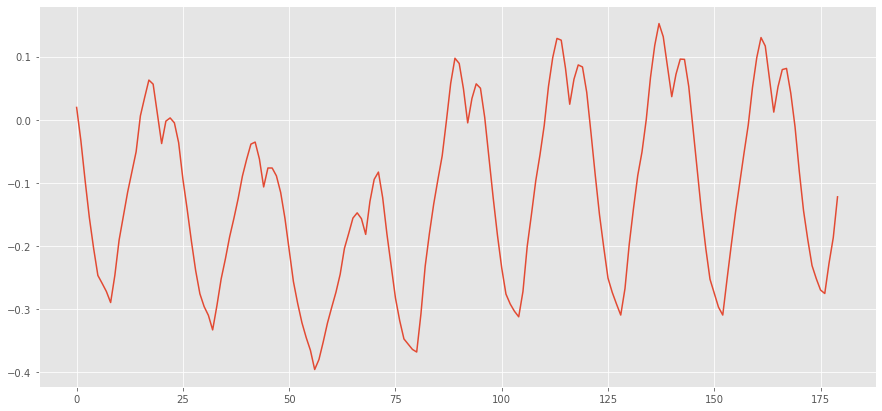

In [27]:
plt.plot(Xf[0,:,0])

<summary>
    <font size="4" color="orange"><b>5.2 Applying the model </b></font>
</summary>

In [28]:
y_est = modelo.predict(Xf)
y_est[:,:,0].ravel().shape

2022-08-12 19:58:57.134363: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2022-08-12 19:58:57.355957: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 19:58:57.418367: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-12 19:58:57.630990: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


(24,)

<summary>
    <font size="4" color="orange"><b>5.2  Setting real vs prediction dataframe </b></font>
</summary>

In [29]:
# Mapping from [-1, 1] to original scale
scaler = scalers['DEMANDA']
yh = scaler.inverse_transform(y_est[:,:,0].ravel().reshape(-1, 1))

In [30]:
# Creating data time-line for the day to forecasting

def predict_dates(num_prediction):
    last_date = df_pronostico['FECHA-HORA'].iloc[-1]
    prediction_dates = pd.date_range(last_date, periods=num_prediction+13, freq='H').tolist()
    return prediction_dates

num_prediction = 24
forecast_dates = predict_dates(num_prediction)
forecast_dates
str_list = [t.strftime("%Y-%m-%d %H:%M:%S") for t in forecast_dates]
str_list = str_list[13:]

In [31]:
str_list

['2022-04-30 00:00:00',
 '2022-04-30 01:00:00',
 '2022-04-30 02:00:00',
 '2022-04-30 03:00:00',
 '2022-04-30 04:00:00',
 '2022-04-30 05:00:00',
 '2022-04-30 06:00:00',
 '2022-04-30 07:00:00',
 '2022-04-30 08:00:00',
 '2022-04-30 09:00:00',
 '2022-04-30 10:00:00',
 '2022-04-30 11:00:00',
 '2022-04-30 12:00:00',
 '2022-04-30 13:00:00',
 '2022-04-30 14:00:00',
 '2022-04-30 15:00:00',
 '2022-04-30 16:00:00',
 '2022-04-30 17:00:00',
 '2022-04-30 18:00:00',
 '2022-04-30 19:00:00',
 '2022-04-30 20:00:00',
 '2022-04-30 21:00:00',
 '2022-04-30 22:00:00',
 '2022-04-30 23:00:00']

In [32]:
# Real load energy demand 

#2022-03-24
#forecast_real_data = [2416,2312,2229,2170,2129,2083,2089,2128,2162,2270,2376,2429,
#                      2498,2543,2580,2617,2655,2702,2712,2623,2607,2664,2648,2576]

#2022-03-25
#forecast_real_data = [2475,2363,2272,2214,2160,2119,2120,2153,2150,2231,2344,2433,2512,
#                      2582,2611,2679,2714,2736,2741,2687,2655,2696,2654,2565]

#2022-03-26
#forecast_real_data = [2495,2418,2323,2248,2191,2156,2147,2173,2154,2259,2398,2471,2535,
#                        2606,2643,2669,2674,2689,2684,2616,2571,2617,2570,2506]

#2022-04-30
forecast_real_data = [3151,3042,2923,2798,2695,2608,2550,2473,2420,2520,2658,2774,2852,2907,
                      2984,3074,3141,3189,3194,3123,2991,3052,3072,3065]


len(forecast_real_data)

24

In [33]:
# Adding real load energy demand to "consumo" dataframe   ¿¿¿Esto para qué es???
demanda_real = consumo.Demanda[-24:].values.tolist()
for i in range(24):
    demanda_real.append(forecast_real_data[i])

In [34]:
# Real vs prediction dataframe
df_est = pd.DataFrame({
    "Real": forecast_real_data,
    "Estimado": yh.ravel(),
    "Fecha-Hora": str_list 
})

In [35]:
df_est

,Real,Estimado,Fecha-Hora
0,3151,3100.813477,2022-04-30 00:00:00
1,3042,3024.001465,2022-04-30 01:00:00
2,2923,2924.233398,2022-04-30 02:00:00
3,2798,2814.413330,2022-04-30 03:00:00
4,2695,2712.602295,2022-04-30 04:00:00
5,2608,2630.100098,2022-04-30 05:00:00
6,2550,2564.918701,2022-04-30 06:00:00
7,2473,2511.285400,2022-04-30 07:00:00
8,2420,2483.402100,2022-04-30 08:00:00
9,2520,2524.638184,2022-04-30 09:00:00


In [36]:
# obteniendo variable hora para los datos
df_est['Fecha-Hora']= pd.to_datetime(df_est['Fecha-Hora'])
df_est["Hora"] = df_est['Fecha-Hora'].dt.hour
df_est

,Real,Estimado,Fecha-Hora,Hora
0,3151,3100.813477,2022-04-30 00:00:00,0
1,3042,3024.001465,2022-04-30 01:00:00,1
2,2923,2924.233398,2022-04-30 02:00:00,2
3,2798,2814.413330,2022-04-30 03:00:00,3
4,2695,2712.602295,2022-04-30 04:00:00,4
5,2608,2630.100098,2022-04-30 05:00:00,5
6,2550,2564.918701,2022-04-30 06:00:00,6
7,2473,2511.285400,2022-04-30 07:00:00,7
8,2420,2483.402100,2022-04-30 08:00:00,8
9,2520,2524.638184,2022-04-30 09:00:00,9


In [37]:
#df_est.to_excel('./dorecsat2dias.xlsx')

## 6.  Model evaluation

In [42]:
import plotly.graph_objects as go
from plotly.offline import iplot

fig = go.Figure()
fig.add_trace(go.Scatter(x=df_est['Fecha-Hora'], y=df_est['Real'],
                    mode='lines+markers',
                    name='Real'))
fig.add_trace(go.Scatter(x=df_est['Fecha-Hora'], y=df_est['Estimado'],
                    mode='lines+markers',
                    name='Forecast'))

fig.show()
iplot(fig, image='svg', filename='lstm-ed_forecast_2022-04-30_mape093_r2_99', image_width=1280, image_height=640)

In [39]:
# Getting MAPE and R2

real=[]
estimada =[]

df_est_result = pd.DataFrame(columns=['Fecha-Hora',"mape"])

for i, row in df_est.iterrows():

    n = row['Hora']
    
    real.append(row['Real'])
    estimada.append(row['Estimado'])
    
   
    if n == 23:
        df_est_result = df_est_result.append(pd.DataFrame({
                                           "Fecha": row['Fecha-Hora'].strftime("%Y-%m-%d") ,
                                           "mape": (mean_absolute_percentage_error(real, estimada))*100, 
                                           "r2": stats.pearsonr(real, estimada)[0]}, 
                                            index=[0]), ignore_index=True)
        n=0
        
        real=[]
        estimada =[]
    n+=1


In [40]:
# Resulting score
df_est_result = df_est_result[['Fecha','mape','r2']].style.hide_index()
df_est_result

Fecha,mape,r2
2022-04-30,0.938668,0.995132


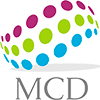

In [41]:
from IPython import display
display.Image("https://mcd.unison.mx/wp-content/themes/awaken/img/logo_mcd.png", embed = True)

<summary>
    <font size="4" color="gray"> Maestría en Ciencia de Datos | Universidad de Sonora </font>
</summary>
<font size="1" color="gray"> Blvd. Luis Encinas y Rosales s/n Col. Centro. Edificio 3K1 planta baja C.P. 83000, Hermosillo, Sonora, México </font>
<font size="1" color="gray"> mcd@unison.mx </font>
<font size="1" color="gray"> Tel: +52 (662) 259 2155  </font>